<a href="https://colab.research.google.com/github/cange017/Stock-Market-Predictor/blob/master/sp500_stock_price_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json 
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

In [88]:
import pandas
df = pandas.read_csv('/content/drive/My Drive/Colab Notebooks/applestock.csv')
print(df)

            date      open      high       low     close
0     12/12/1980    0.5134    0.5155    0.5134    0.5134
1     12/15/1980    0.4889    0.4889    0.4866    0.4866
2     12/16/1980    0.4530    0.4530    0.4509    0.4509
3     12/17/1980    0.4620    0.4643    0.4620    0.4620
4     12/18/1980    0.4755    0.4777    0.4755    0.4755
5     12/19/1980    0.5045    0.5068    0.5045    0.5045
6     12/22/1980    0.5291    0.5313    0.5291    0.5291
7     12/23/1980    0.5514    0.5536    0.5514    0.5514
8     12/24/1980    0.5804    0.5827    0.5804    0.5804
9     12/26/1980    0.6339    0.6361    0.6339    0.6339
10    12/29/1980    0.6429    0.6452    0.6429    0.6429
11    12/30/1980    0.6295    0.6295    0.6271    0.6271
12    12/31/1980    0.6116    0.6116    0.6095    0.6095
13      1/2/1981    0.6161    0.6205    0.6161    0.6161
14      1/5/1981    0.6048    0.6048    0.6027    0.6027
15      1/6/1981    0.5780    0.5780    0.5759    0.5759
16      1/7/1981    0.5536    0

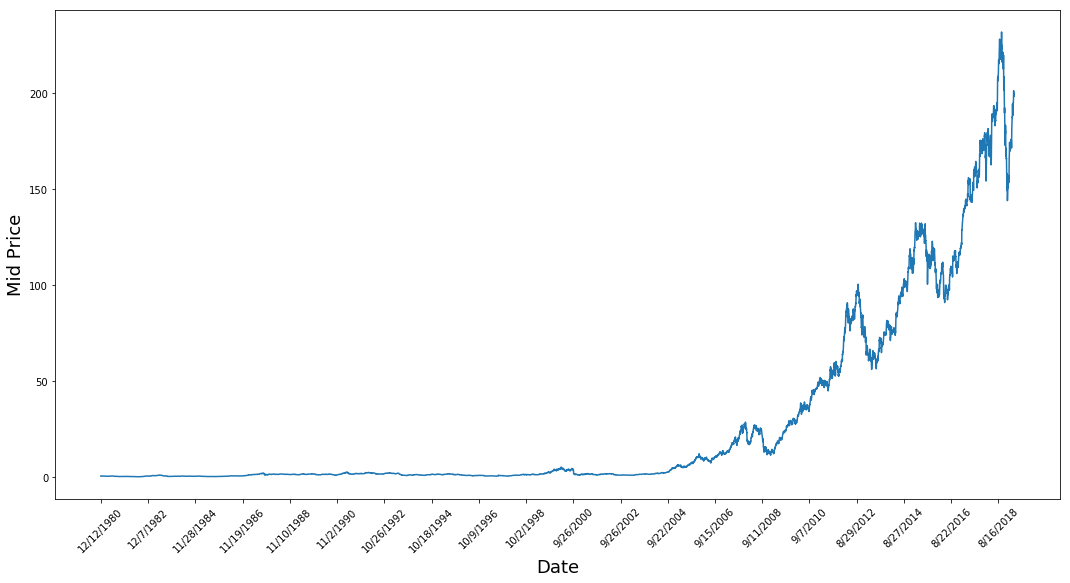

In [90]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['low']+df['high'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [92]:
# First calculate the mid prices from the highest and lowest 
high_prices = df.loc[:,'high'].as_matrix()
low_prices = df.loc[:,'low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [0]:
train_data = mid_prices[:6000]
test_data = mid_prices[6000:]

In [0]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data w.r.t training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [0]:
# Train the Scaler with training data and smooth data 
smoothing_window_size = 2500
for di in range(0,5000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data 
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [0]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [0]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(6000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [98]:
class DataGeneratorSeq(object):
    
    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):
        
        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)
        
        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)
                
            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(1,5)]
            
            self._cursor[b] = (self._cursor[b]+1)%self._prices_length
            
        return batch_data,batch_labels
    
    def unroll_batches(self):
            
        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):
            
            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels
    
    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))
        


dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.01667544 0.04035686 0.6487947  0.20690165 0.6347066 ]

	Output: [0.03027858 0.04082232 0.6478778  0.20614842 0.6646343 ]


Unrolled index 1
	Inputs:  [0.03027858 0.0409037  0.6479785  0.20650521 0.649143  ]

	Output: [0.05055054 0.04098548 0.6484198  0.20614842 0.6646343 ]


Unrolled index 2
	Inputs:  [0.0406379  0.04098548 0.6484198  0.20614842 0.6603831 ]

	Output: [0.08084071 0.04425292 0.6441404  0.1960551  0.6646343 ]


Unrolled index 3
	Inputs:  [0.05055054 0.04082232 0.6478778  0.20502199 0.6646343 ]

	Output: [0.07037404 0.04540452 0.6456994  0.19319467 0.6587631 ]


Unrolled index 4
	Inputs:  [0.06017955 0.04161724 0.64704275 0.2021613  0.6670903 ]

	Output: [0.09143397 0.04540452 0.6444946  0.1960551  0.65579605]


In [0]:
D = 1 # Dimensionality of the data. Since our data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() # This is important in case you run this multiple times

In [0]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

In [0]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

In [0]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of 
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

In [103]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


In [104]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


In [121]:
import time
epochs = 35
valid_summary = 1 # Interval you make test predictions

n_predict_once = 50 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings) 

x_axis_seq = []

# Points you start our test predictions from
test_points_seq = np.arange(6000,7000,50).tolist() 

for ep in range(epochs):       
    start = time.time()
    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):
        
        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)
        
        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l
    
    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))
      
      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))
      
      train_mse_ot.append(average_loss)
            
      average_loss = 0 # reset loss
      
      predictions_seq = []
      
      mse_test_loss_seq = []
      
      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []
        
        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]
        
        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)
        
        feed_dict = {}
        
        current_price = all_mid_data[w_i-1]
        
        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)
        
        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)
        
          our_predictions.append(np.asscalar(pred))
        
          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2
        
        session.run(reset_sample_states)
        
        predictions_seq.append(np.array(our_predictions))
        
        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)
        
        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)
        
      current_test_mse = np.mean(mse_test_loss_seq)
      
      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0
      
      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')
      
      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')
      end = time.time()
      print (end-start)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized
Average loss at step 1: 1.626530
	Test MSE: 6.71959
	Finished Predictions
8.939944982528687
Average loss at step 2: 0.295236
	Test MSE: 6.31758
	Finished Predictions
8.41640329360962
Average loss at step 3: 0.132994
	Test MSE: 4.77263
	Finished Predictions
8.244395017623901
Average loss at step 4: 0.085878
	Test MSE: 4.80618
	Finished Predictions
8.206732273101807
Average loss at step 5: 0.063618
	Test MSE: 4.69008
	Finished Predictions
8.226014614105225
Average loss at step 6: 0.064390
	Test MSE: 4.46865
	Finished Predictions
8.247478008270264
Average loss at step 7: 0.064262
	Test MSE: 4.46606
	Finished Predictions
8.132779121398926
Average loss at step 8: 0.065174
	Test MSE: 4.37482
	Finished Predictions
8.266193866729736
Average loss at step 9: 0.055193
	Test MSE: 4.12221
	Finished Predictions
8.246984243392944
Average loss at step 10: 0.048628
	Test MSE: 4.25725
	Finished Predictions
8.237290143966675
Average loss at step 11: 0.045913
	Test MSE: 4.64848
	Finished Predi

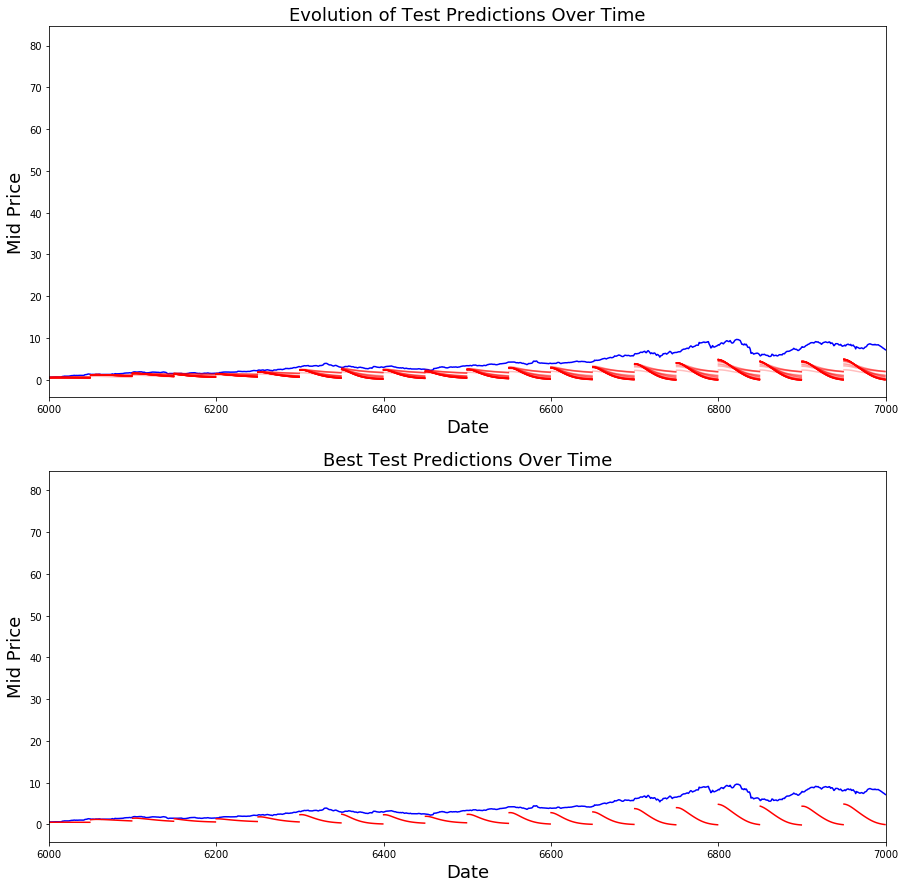

In [122]:
best_prediction_epoch = 34 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (15,15))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(6000,7000)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')
    
plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(6000,7000)
plt.show()